In [111]:
import torch
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

In [112]:
words = open('names.txt','r').read().splitlines()

In [113]:
stoi = {v:i+1 for i,v in enumerate(sorted(list(set(''.join(words)))))}
stoi['.'] = 0
itos = {v:k for k,v in stoi.items()}

In [131]:
# creating the dataset
# split the dataset into
# train, dev/val , test
# 80 %, 10 % , 10 %
# used for training the model, used for hyperparameter optimization, used for testing the model
def prepare_dataset(words):
  block_size = 3
  X = []
  y = []
  for w in words:
    context = block_size * [0]
    for c in w+'.':
      X.append(context)
      y.append(stoi[c])
      # print(f"{''.join([itos[con] for con in context])} --> {c}")
      context = context[1:] + [stoi[c]]
  X = torch.tensor(X)
  y = torch.tensor(y)
  return X,y
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_train,y_train = prepare_dataset(words[:n1])
X_val,y_val = prepare_dataset(words[n1:n2])
X_test,y_test = prepare_dataset(words[n2:])

In [132]:
X_train[0]

tensor([0, 0, 0])

In [133]:
X_train.shape

torch.Size([182580, 3])

In [197]:
g = torch.Generator().manual_seed(12345)
# Embedding layer
C = torch.randn((27,2))
#hiddenlayer
W1 = torch.randn((6,300))
b1 = torch.randn(300)
# output layer
W2 = torch.randn((300,27))
b2 = torch.randn(27)
params = [C,W1,b1,W2,b2]
for p in params:
  p.requires_grad=True

In [198]:
embeds = C[X_train]

In [199]:
torch.cat([embeds[:,0,:],embeds[:,1,:],embeds[:,2,:]],dim=1)

tensor([[-0.2746, -0.2778, -0.2746, -0.2778, -0.2746, -0.2778],
        [-0.2746, -0.2778, -0.2746, -0.2778,  1.6752, -0.3602],
        [-0.2746, -0.2778,  1.6752, -0.3602, -0.9219, -1.0014],
        ...,
        [ 0.7790,  0.5003,  0.2136, -1.7920, -0.3493,  0.3677],
        [ 0.2136, -1.7920, -0.3493,  0.3677, -0.3493,  0.3677],
        [-0.3493,  0.3677, -0.3493,  0.3677,  0.7281, -1.3173]],
       grad_fn=<CatBackward0>)

In [200]:
torch.cat(torch.unbind(embeds,1),dim=1)

tensor([[-0.2746, -0.2778, -0.2746, -0.2778, -0.2746, -0.2778],
        [-0.2746, -0.2778, -0.2746, -0.2778,  1.6752, -0.3602],
        [-0.2746, -0.2778,  1.6752, -0.3602, -0.9219, -1.0014],
        ...,
        [ 0.7790,  0.5003,  0.2136, -1.7920, -0.3493,  0.3677],
        [ 0.2136, -1.7920, -0.3493,  0.3677, -0.3493,  0.3677],
        [-0.3493,  0.3677, -0.3493,  0.3677,  0.7281, -1.3173]],
       grad_fn=<CatBackward0>)

In [201]:
emb = embeds.view(embeds.shape[0],6)

In [202]:
h = torch.tanh(emb @ W1 + b1)

In [203]:
h.shape

torch.Size([182580, 300])

In [204]:
logits = h @ W2 + b2
logits.shape

torch.Size([182580, 27])

In [205]:
# log likelihood loss
# exp_log = logits.exp()
# out = exp_log / exp_log.sum(dim=1,keepdims=True)
# loss = -torch.log(out[torch.arange(out.shape[0]),y]).sum()
# loss = loss/out.shape[0]

loss = F.cross_entropy(logits,y_train)

In [206]:
# for finding the optimal learning rate
# first get the lower range where the loss doesn't change much and get the higher range where the loss explodes
# Then use torch.arange along that range to create the exponents and test out all the lrs
# plot the lr exponents on the x axis and their respective losses on the y axis and then you can find the exponent which gives lowest loss
# if you think the loss is not decreasing much after training lower the learning rate by a tenth

In [212]:
# using mini batches instead of the whole dataset
epochs = []
losses = []
for epoch in range(50000):
  ix = torch.randint(0,X_train.shape[0],(128,))
  embeds = C[X_train[ix]]
  emb = embeds.view(embeds.shape[0],6)
  h = torch.tanh(emb @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,y_train[ix])
  for p in params:
    p.grad = None
  loss.backward()
  for p in params:
    p.data += -0.01 * p.grad
  epochs.append(epoch)
  losses.append(loss.item())
print(loss.item())

2.390127420425415


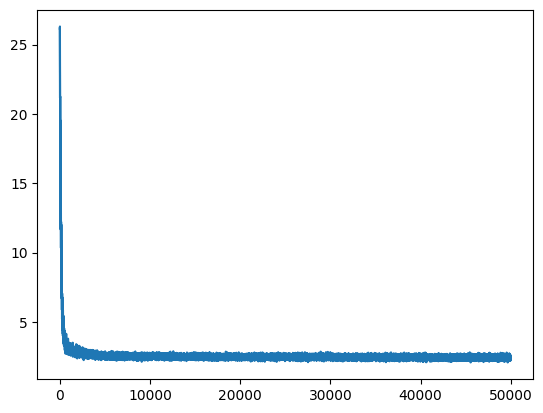

In [208]:
plt.plot(epochs,losses)

In [211]:
embeds = C[X_val]
embeds = embeds.view(embeds.shape[0],6)
h = torch.tanh(embeds @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,y_val)
print("Val Loss: ",loss)

Val Loss:  tensor(2.3852, grad_fn=<NllLossBackward0>)


In [156]:
embeds = C[X_train]
embeds = embeds.view(embeds.shape[0],6)
h = torch.tanh(embeds @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,y_train)
print("Training Loss: ",loss)

Training Loss:  tensor(2.3213, grad_fn=<NllLossBackward0>)


In [76]:
# As the training and validation loss around equal we are not overfitting and we are underfitting instead so this means that we should use a larger model
# as this model is not powerful enough
# lower batch size can lead to more noise

tensor([ 53449,  81964, 186548,  58230, 113948,  68904, 176596,  59478,  24312,
        112070, 207824,  95448,  33102, 206488, 222061, 226575,  46171,  69746,
         34752, 219314,   7628, 200782, 110374,  55227, 197718,  84128, 131386,
        167008, 219453, 145935,  31119, 146829,  74692, 107050,   4407,  63357,
         53374,  87173,  70708, 128655,  45855,  47580, 211383, 109303, 135681,
         48260,  67367,  48250, 170414,  76090, 146699,  83498,  93031, 179688,
        184634, 149344, 171388, 198089,  17762, 113641, 177292,  40089, 129203,
        178057])

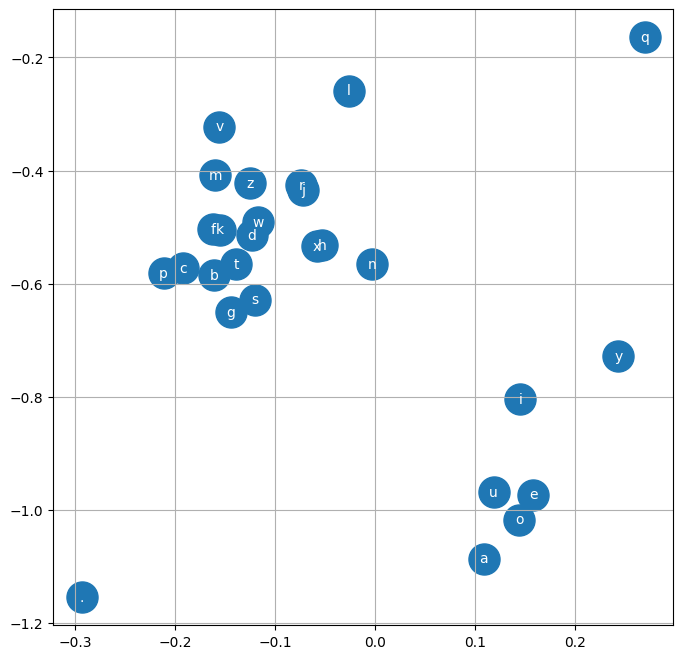

In [215]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=500)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')